# 1. ESDA with rgeoda and sp

Previous “introduction” page shows you:

1. how to install rgeoda,
2. how to load a spatial dataset and create a rgeoda instance
3. how to access attribute data in rgeoowda instance
4. how to create a Queen contiguity weights
5. how to compute local indicators of spatial autocorrelation (LISA) using the Queen contiguity weights
6. how to apply a spatially constrained clustering algorithm (SKATER) to find clusters

For people who using R to do spatial data analysis, a common routine is to use `rgdal` package to read spatial dataset, and then use `sp` package, or (in recent) `sf` package, to handle and analyze spatial data and plot the results on maps.

rgeoda provides utility functions to create an `GeoDa` instance from an `sp` object or `sf` object, so that users can easily integrate the functions of spatial data analysis in rgeoda into their existing work.

In this note, I will demonstrate how to work with `sp` and `rgeoda` package to do exploratory spatial data analysis (ESDA).

## Start from sp package

The sp package has been an essential tool which provides spatial data-structures and many utility functions to do spatial analysis in R. It has been a core dependent library for many other packages, e.g. rgdal (IO), maptools (mapping), spdep (spatial weights, spatial statistics, and spatial models) etc.

Using rgdal to read a ESRI Shapefile will return a sp (Spatial object) object, which could be either a SpatialPointsDataFrame (using an AttributeList for its data slot directly), a SpatialLinesDataFrame, or a SpatialPolygonsDataFrame.

In [1]:
guerry_path <- system.file("extdata", "Guerry.shp", package = "rgeoda")

In [2]:
library(rgdal)

Warning message:
“package ‘rgdal’ was built under R version 3.5.2”Loading required package: sp
rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgdal/proj
 Linking to sp version: 1.3-1 


call `readOGR()` function to read Guerry.shp file and this function will returns an `sp` object

In [3]:
guerry_sp <- readOGR(guerry_path)

OGR data source with driver: ESRI Shapefile 
Source: "/Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgeoda/extdata/Guerry.shp", layer: "Guerry"
with 85 features
It has 26 fields
Integer64 fields read as strings:  dept Crm_prs Crm_prp Litercy Donatns Infants Suicids MainCty Wealth Commerc Clergy Crm_prn Infntcd Dntn_cl Lottery Desertn Instrct Prsttts Area 


You can simply call plot() function to plot this map:

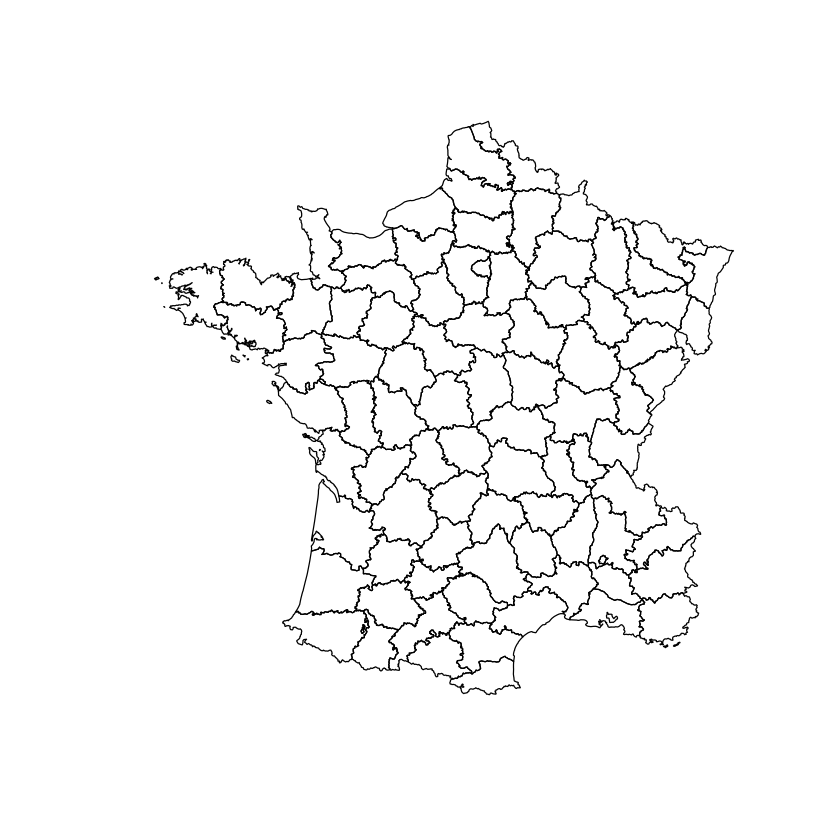

In [4]:
plot(guerry_sp)

## Create rgeoda object from sp

Everything above should be very familiar with you, right? Then, the fun part of spatial data analysis is going to start:

Create a rgeoda object from the sp object guerry_sp you just created.

In [5]:
library(rgeoda)

guerry_gda <- sp_to_geoda(guerry_sp)

Loading required package: wkb


That’s it! It should be very fast: rgeoda uses `wkb`, which is a binary representation of geometries, to exchange data between sp and rgeoda in memory.


## ESDA with rgeoda

Now, with the rgeoda object `guerry_gda`, you can call GeoDa’s spatial analysis functions easily. For example, we want to examine the local Moran of variable “crm_prs” (Population per Crime against persons):



In [6]:
queen_w <- guerry_gda$CreateContiguityWeights()
crm_lisa <- guerry_gda$LISA(queen_w, as.numeric(paste(guerry_sp$Crm_prs)))
crm_lisa_clusters <- crm_lisa$GetClusterIndicators()

Now, with the LISA results, we can do exploratory spatial data analysis by generating a LISA cluster map:

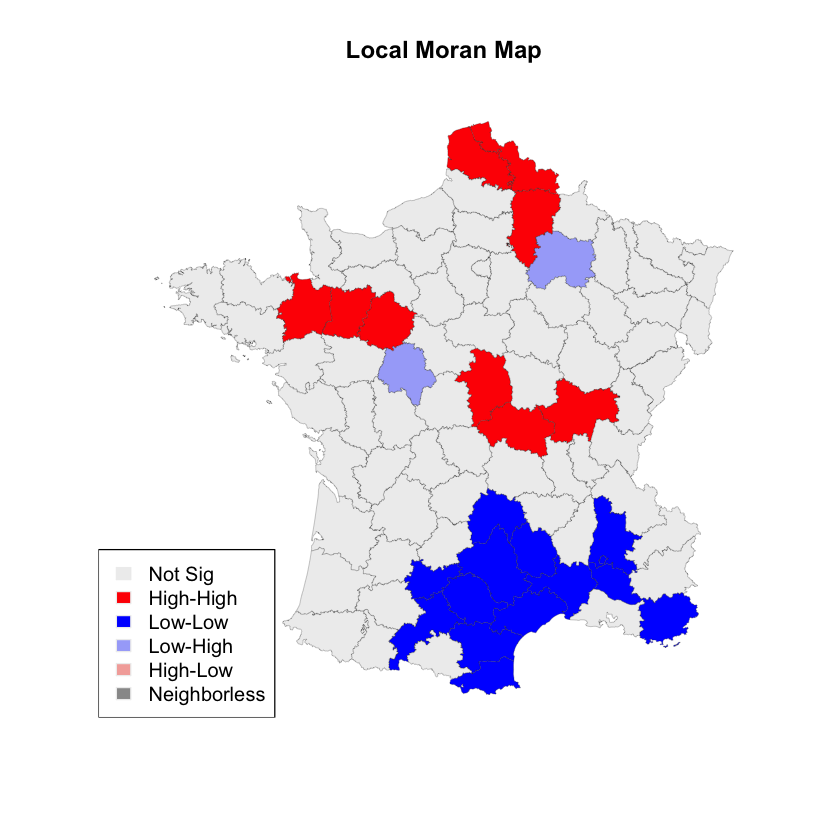

In [11]:
lisa_colors <- c("#eeeeee","#FF0000","#0000FF","#a7adf9", "#f4ada8", "#999999")
lisa_labels <- c("Not Sig", "High-High", "Low-Low", "Low-High","High-Low", "Neighborless")

plot(guerry_sp, 
     col=sapply(crm_lisa_clusters, function(x){return(lisa_colors[[x+1]])}), 
     border = "#333333", lwd=0.2)
title(main = "Local Moran Map")
legend('bottomleft', legend = lisa_labels, fill = lisa_colors, border = "#eeeeee")

From the above code, you can see that we still use `sp` object to do plotting. The values of cluster indicators from rgeoda’s `LISA` object are used to make the LISA map.This emphasis that rgeoda is a API focused library, which only provides the core functions of spatial data analysis for easy integration.

You can easily append the lisa results to original sp object by manipulating the data.frame object inside the sp object.

If you check the values of the cluster indicators, you will see they are integer numbers 0 (not significant), 1 (high-high cluster), 2 (low-low cluster), 3 (low-high cluster), 4 (high-low cluster), 5 (neighborless/island), 6 (undefined), which are excatly the same with GeoDa software when you save LISA results to a table:

In [12]:
crm_lisa_clusters

[1] 0 1 1 0 0 0 0 0 0 2 2 0 0 2 0 0 1 0 0 0 0 0 0 2 0 0 0 2 2 0 0 2 1 0 3 0 0 0
[39] 0 0 0 0 0 0 0 2 0 0 3 0 1 0 0 0 0 0 1 0 0 1 0 0 0 2 0 0 0 0 1 1 0 0 0 0 0 0
[77] 2 2 2 2 0 0 0 0 0

We also specify what color is associated with which cluster value to replace the `lisa_colors` and `lisa_labels`, which are defined in `sf_geoda.R`:

'''
lisa_colors <- c("#eeeeee","#FF0000","#0000FF","#a7adf9", "#f4ada8", "#999999")
'''

We then create an array of hex color, each observation is set to a hex color according to its cluster indicator value.



In [13]:
sapply(crm_lisa_clusters, function(x){return(lisa_colors[[x+1]])})


[1] "#eeeeee" "#FF0000" "#FF0000" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee"
 [8] "#eeeeee" "#eeeeee" "#0000FF" "#0000FF" "#eeeeee" "#eeeeee" "#0000FF"
[15] "#eeeeee" "#eeeeee" "#FF0000" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee"
[22] "#eeeeee" "#eeeeee" "#0000FF" "#eeeeee" "#eeeeee" "#eeeeee" "#0000FF"
[29] "#0000FF" "#eeeeee" "#eeeeee" "#0000FF" "#FF0000" "#eeeeee" "#a7adf9"
[36] "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee"
[43] "#eeeeee" "#eeeeee" "#eeeeee" "#0000FF" "#eeeeee" "#eeeeee" "#a7adf9"
[50] "#eeeeee" "#FF0000" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee"
[57] "#FF0000" "#eeeeee" "#eeeeee" "#FF0000" "#eeeeee" "#eeeeee" "#eeeeee"
[64] "#0000FF" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#FF0000" "#FF0000"
[71] "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee" "#0000FF"
[78] "#0000FF" "#0000FF" "#0000FF" "#eeeeee" "#eeeeee" "#eeeeee" "#eeeeee"
[85] "#eeeeee"